# Create a signal for demonstrating the PFB and its "inversion"

In [1]:
from numpy import sin, arange, pi,shape,log10,zeros

import scipy
from scipy.signal import lfilter, firwin,kaiser,kaiser_beta
from matplotlib import pyplot as plt
#from pylab import figure, plot, grid, show,xlabel,ylabel,legend,imshow,colorbar
from random import random,gauss
from numpy.fft import fft,ifft,fftshift,ifftshift,fftfreq
import numpy as np
import math
import cmath

%matplotlib inline



In [2]:
def db(x):
    """ Convert linear value to dB value """
    return 10*log10(x)

In [3]:
def inv_dft(input,chan):
  output=[]
  stfft = input[0:chan]
  stfft=ifftshift(stfft);
  out=ifft(stfft)
  for samp in out:
    output.append(samp)
  return output


In [4]:
def plot_power(t,amps,keyname="power"):
    power = [abs(s)**2 for s in amps]
    plt.plot(t,power,label = keyname)
    plt.xlabel("Time (s)")
    plt.ylabel("Power")
    plt.legend(loc='upper right')


----------------
## Make a signal:

In [5]:
# Set up the signal properties

nchan = 32
ntaps = 8

nsamp = 1000
nsamples = nsamp*nchan
sample_rate = nchan*nsamp

In [6]:
def make_signal(nsamples,sample_rate):
    """Makes a signal composed of complex-valued white noise"""
    t = []
    signal = []
    for i in range (0,nsamples,1):
        t.append(i * 1.0/sample_rate)
        signal.append(complex(gauss(0.0,1.0),gauss(0.0,1.0)))
    
    return t, signal

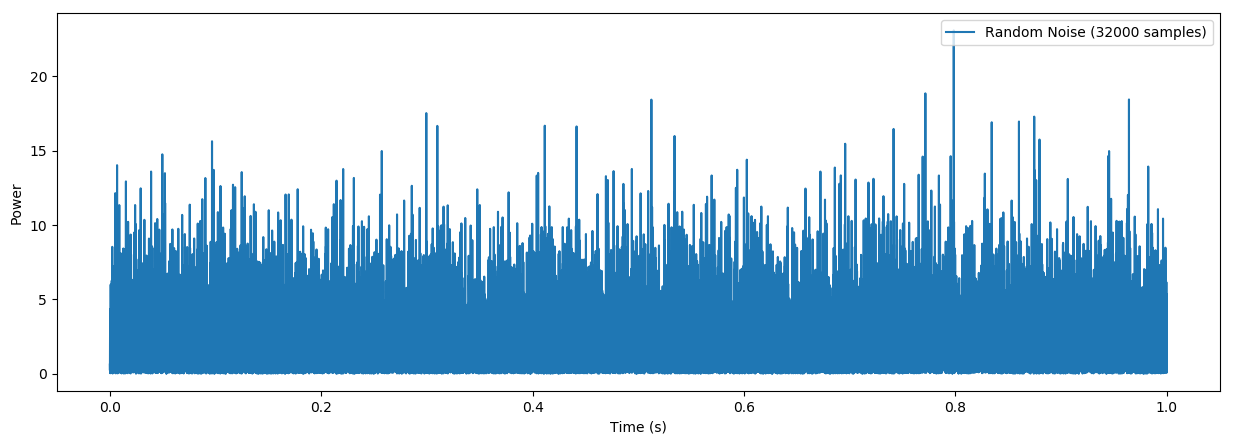

In [7]:
# Make random noise
t, noise = make_signal(nsamples,sample_rate)

# Plot it up
plt.figure(figsize=(15,5))
plot_power(t, noise, "Random Noise ({:d} samples)".format(nsamples))


In [8]:
# Add an impulse to the noise signal

def add_impulse (step,width,scale,signal):
    """ This is multiplicative. I am increasing the power in the specified range """
    result = []
    for i in range(len(signal)):
        result.append(signal[i])
        if (i>step) and (i<=(step+width)):
            result[i] *= scale
    return result

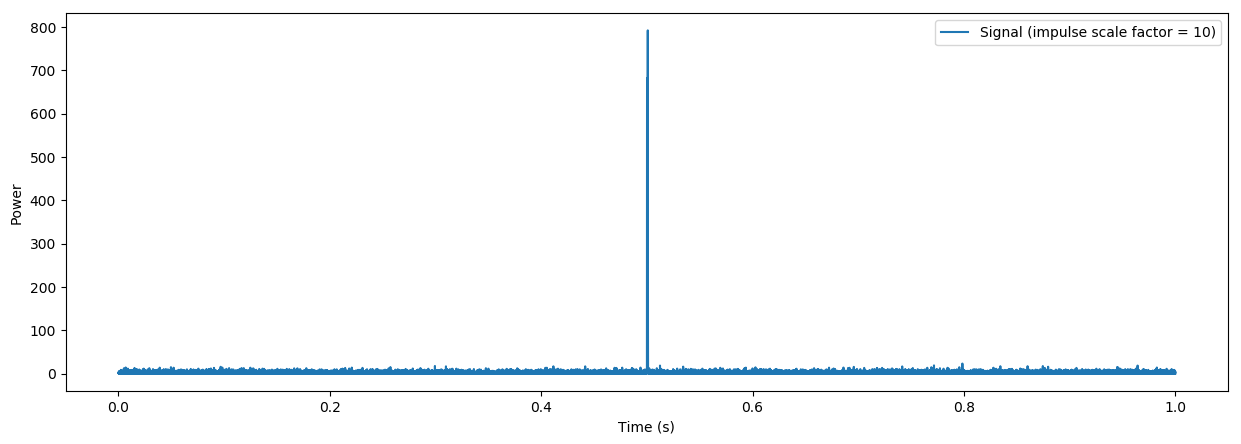

In [9]:
step  = 0.5*nsamples
width = nchan
scale = 10
noise_with_impulse = add_impulse(step,width,scale,noise)

# Plot it up
plt.figure(figsize=(15,5))
plot_power(t, noise_with_impulse, "Signal (impulse scale factor = {:d})".format(scale))

In [10]:
def add_wave(freq,scale,t,signal):
    result = [signal[i]+complex(2*scale*math.cos(2*pi*freq*t[i]),0) for i in range(len(signal))]
    return result

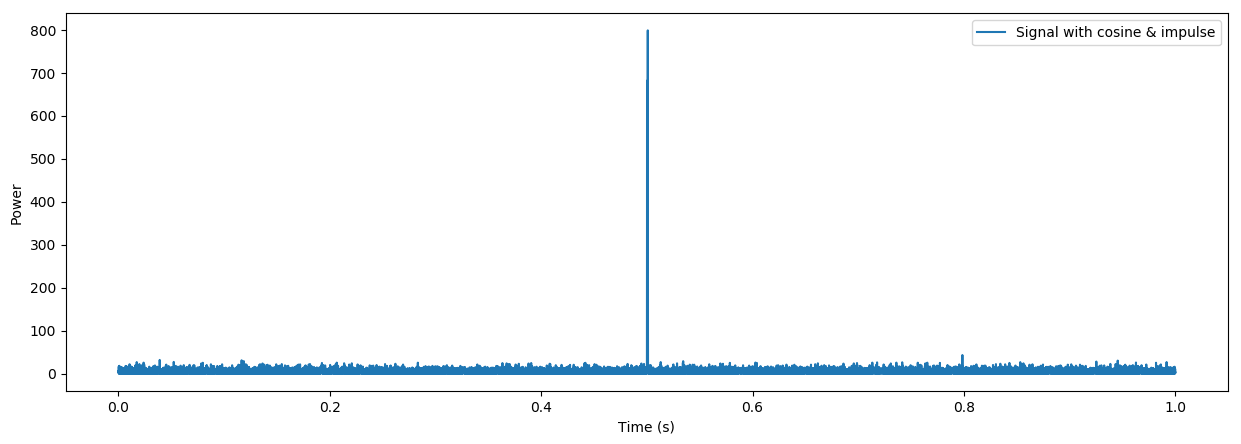

In [11]:
# Add a cosine wave to the signal
freq  = 2000.0
scale = 1.0
signal = add_wave(freq, scale, t, noise_with_impulse)

# Plot it up
plt.figure(figsize=(15,5))
plot_power(t, signal, "Signal with cosine & impulse")

Text(0.5,0,u'Freq (Hz)')

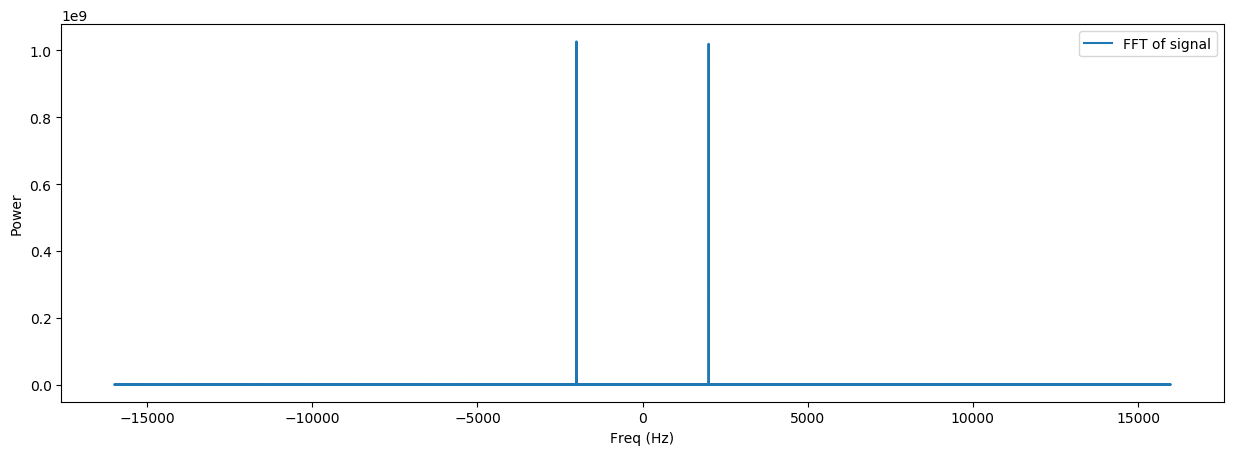

In [12]:
# the spectrogram

spectrum = fft(signal)
freq = fftfreq(len(spectrum), t[1] - t[0])

# Plot it up
plt.figure(figsize=(15,5))
plot_power(freq, spectrum, "FFT of signal")
plt.xlabel("Freq (Hz)")    


----------------------
## Put the signal through a PFB:

In [13]:
def make_filter(numtaps,nchan):
  cof_bit = 12
  ncoeff = numtaps*nchan
  b = firwin(ncoeff,1.0/(nchan))
  b = (1-pow(2,-(cof_bit-1)))*b/max(b);
  window = kaiser(ncoeff,5)
  filter = b*window
  return filter



Text(0,0.5,u'Coefficient value')

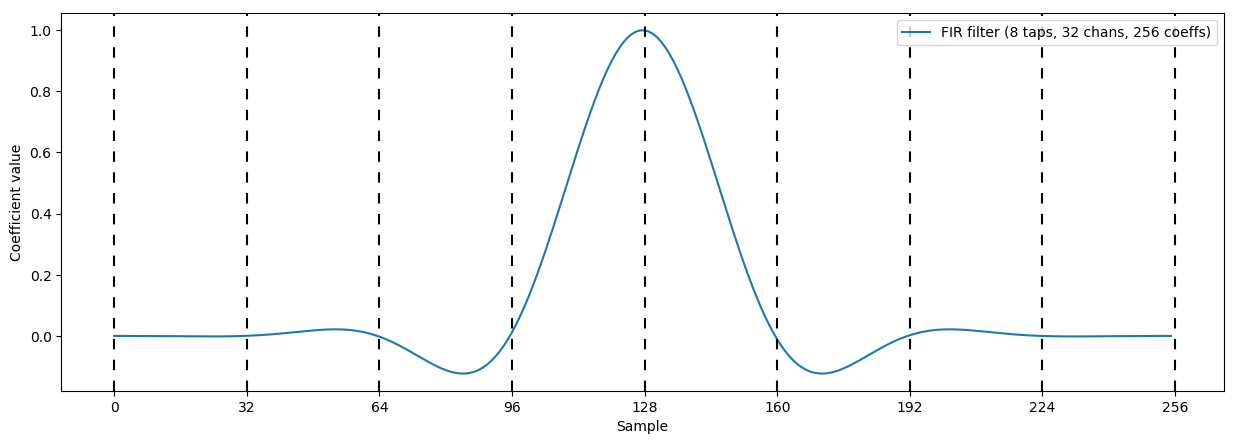

In [14]:
# The Nyquist rate of the signal.
nyq_rate =  sample_rate
cutoff_hz = nyq_rate;

# Use firwin to create a lowpass FIR filter
fir_coeff = make_filter(ntaps,nchan)

# Plot the filter
plt.figure(figsize=(15,5))
plt.plot(fir_coeff, label="FIR filter ({:d} taps, {:d} chans, {:d} coeffs)".format(ntaps, nchan, ntaps*nchan))
for x in range(0,ntaps*nchan+1,nchan):
    plt.axvline(x=x, color='k', dashes=[5,5])
plt.legend(loc='upper right')
plt.xticks(arange(0,257,32))
plt.xlabel('Sample')
plt.ylabel('Coefficient value')


In [15]:
# Use PFB to filter the signal

def pfb(inp, filt, ntaps, nchan, oversample_time):
     # PFB from overlap and Sum
    output = []
    output2 = []
            
    for i in range (0,len(inp)-(ntaps*nchan),int(nchan/oversample_time)):

        #weight
        part_input = inp[i:(i+(ntaps*nchan))]        
        weighted_input = list(reversed(part_input)) * filt

        # Sum over the taps
        output.append([sum(weighted_input[i:(ntaps*nchan):nchan]) for i in range(nchan)])

    return output

oversample_time = 1
filtered_signal = pfb(signal, fir_coeff, ntaps, nchan, oversample_time)

# Apply the FFT
ffted_signal = fft(filtered_signal)

Text(0,0.5,u'Channel #')

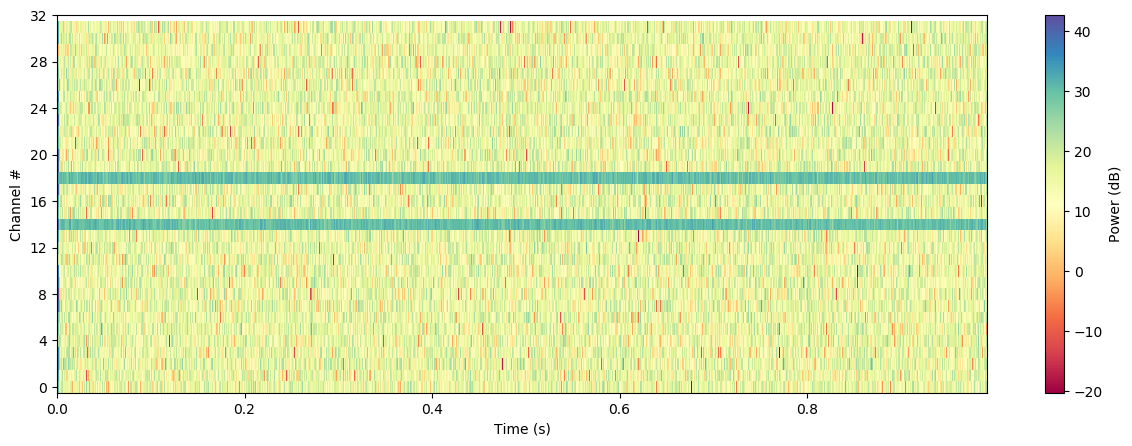

In [16]:
spectrometer = []
time_sample = []

for row in fftshift(ffted_signal):
    time_step = []
    for f in row:
        time_step.append(db(abs(f**2)))
    spectrometer.append(time_step)

s = np.transpose(spectrometer)
last_time = (nsamples-ntaps*nchan)/(1.*nsamples)

plt.figure(figsize=(15,5))
plt.imshow(s, cmap='Spectral', aspect='auto', origin='lower', extent=(0,last_time,-0.5,31.5))
plt.yticks(arange(0,33,4))
plt.colorbar(label="Power (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Channel #")

----------------------
## Apply the inverse PFB:

In [17]:
# the reconstruction (full)
old_recon = 1
if (old_recon):
 
    output=[] 
    upsamp_factor = int(nchan/oversample_time)


    for ch in range(nchan):
    
        channel = []
        for time_samp in range(len(ffted_signal)):
            for upsamp in range (upsamp_factor):
        # first stage is the expanding
                if (upsamp == 0):
                    channel.append(ffted_signal[time_samp][ch])
                else:
                    channel.append(0.0)
    
        #print("Upsampled channel ", ch , " to ", len(channel), " samples")

# we now need to low pass filter this 
# for interpolation purposes
# we have increased the sample rate by a factor of 128
# But the Nyquist rate for this information is still
# the same as before 
#  which means the interpolating filter is actually the same as the FIR
#
# Modulate the filter
        fir_coeff2 = []
        for i,tap in enumerate(fir_coeff):
            fir_coeff2.append(fir_coeff[i] * cmath.rect(1.0,-1.0*ch*2*i*cmath.pi/nchan))
        #print("filtering channel:" ,ch)
        inv_channel = lfilter(fir_coeff2,1.0,channel)
#
        if (ch == 0):
            for entry in inv_channel:
                output.append(entry)
        else:
            for i,entry in enumerate(inv_channel):
                output[i] = output[i] + entry

          


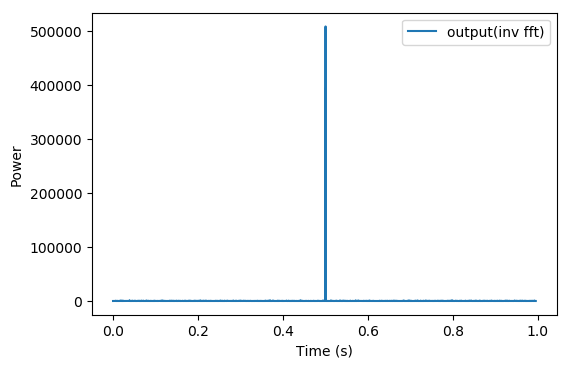

In [19]:
fft_inv = 1
if (fft_inv):
    simple_out = []
  
    for time_samp in range(0,len(ffted_signal)):
      
        to_fft=[]
        for chan_num in range (0,len(ffted_signal[time_samp])):
            chan_val = ffted_signal[time_samp][chan_num]
            to_fft.append(chan_val)
           
        
        for samp in ifft(to_fft):
            simple_out.append(samp)
        
    
    #get the shift
   # xcor1 = fft(simple_out)
   # xcor2 = fft(output)
   # xcor3 = np.conj(xcor1)*(xcor2)
   # xcor4 = ifft(xcor3)
    
    
   # max_index = np.argmax(xcor4)
   # print(len(xcor3))
   # print(max_index)
    
    toplot = []
    shifted = []
    shift = 100
    for x in range(0,shift):
        shifted.append(0)

    for x,samp in enumerate(simple_out):
        if (x>(0)):
            shifted.append(abs(samp**2))
            toplot.append(abs(samp**2))
    
        

    plt.figure(1)
    
    plot_power(t[:len(shifted)],shifted,'output(inv fft)')  

In [27]:
# A second way of achieving the same thing (i.e. PFB "inversion"), hopefully

upsamp_factor = int(nchan/oversample_time)

max_shift = int(ntaps*oversample_time)

centre_chan = 16
shifted_and_reduced = np.zeros(len(ffted_signal)*upsamp_factor + max_shift)

# Shift and reduce first
for i in range(len(ffted_signal)):
    for ch in range(nchan):
        # Calculate the index of the shifted_and_reduced array
        # for this time sample and channel
        i_out = i*upsamp_factor + ch
        shifted_and_reduced[i_out] += ffted_signal[i][ch]

# Now slide the filter, multiply, and FFT
output2 = []
#for i in range(len(ffted_signal)):
for i in range(1):
    first = i*upsamp_factor
    last  = i + ntaps*nchan
    
    #output2 = ifft([a*b for a,b in zip(shifted_and_reduced[first:last], fir_coeff)])
    x = [a*b for a,b in zip(shifted_and_reduced[first:last], fir_coeff)]

print(shifted_and_reduced[first:last]
     )

[-9.44196997169647e-05, -3.4831539819606054e-05, -0.0024943249902595259, -0.00013521548485305045, -0.00051263364366589551, 0.0013994922950178108, 0.00039135419480761845, 0.0022129010170838979, -0.0018872943458898275, -0.00093628874966061849, -0.0018441966302976897, -0.0048758936249803167, -0.00091075493474325182, 0.0038809904592114535, 0.0059961802055220519, 0.008619626722677352, 0.0038355107763203191, 0.0034325851363416152, -0.0030019157355444404, 0.0027029506901344561, 0.012755206897918805, 0.013265433105021493, 0.0011967599838647671, -0.0052958836573564127, -0.018546072341010262, -0.00095391254951949622, -0.0014998021136842612, -0.0039784764223963851, -0.0033499373701996044, 0.0084539021110810481, -0.015674538378368134, -0.0009113597340173116, 0.0016462188508208693, 0.0020304386002900788, 0.040012663163109294, -0.022936416755212397, -0.010865397815441449, -0.040151083871840035, 0.0029310712062897088, -0.02513767574664107, -0.046097784102410853, -0.087265085269012485, -0.097700193176

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:16: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
for x,sig in enumerate(output):
    output[x] = output[x]/(nchan*oversample_time)


In [ ]:
toplot = []




for x,samp in enumerate(output):
    if (x>0):
        
        toplot.append(abs(samp**2))
    
        

plt.figure(1)    
plt.plot(t[:len(toplot)],toplot,label = 'output')  
plt.xlabel("Time (s)")
plt.ylabel("Power")
plt.legend(loc='upper right')      

In [ ]:
spectrum = fft(output)
toplot = []
for samp in spectrum:
    toplot.append(abs((samp)**2))
          
freq = fftfreq(len(spectrum), (t[1] - t[0]))

plt.figure(2)
    
plt.plot(freq,toplot,label = 'output (reconstructed) spectrum')  
plt.xlabel("Freq(Hz)")
plt.ylabel("Power")
plt.legend(loc='upper right')


